# IMDb Prediction Analysis
## Post-Neural-Network Training...
Now that the multi-layer preceptron deep learning model has finished training and producing results from 3 separate training sets, I will conduct some analysis to evaluate how well the model performed.

In [1]:
import os
import csv
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define directory structure
parent_path = '/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/'
prediction_folder = 'prediction_results/'
prediction_path = parent_path + prediction_folder

## Importing Prediction Results...

In [3]:
# Get list of original prediction results
pred_ext = '.csv'
print 'Names of movie prediction files:'
pred_files = []
for filename in os.listdir(prediction_path):
    if filename.endswith(pred_ext):
        pred_files.append(prediction_path + filename)
        print prediction_path + filename

Names of movie prediction files:
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/movie_prediction_2.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/movie_prediction_3.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/movie_prediction_1.csv


In [4]:
# Make new folder for formatted prediction results
format_folder = prediction_path + 'formatted_predictions/'
if not os.path.exists(format_folder):
    print 'Making folder for storing formatted prediction results...'
    os.mkdir(format_folder)
else:
    print 'Folder for storing formatted prediction results already exist!'

Folder for storing formatted prediction results already exist!


In [5]:
# Get list of cleaned prediction results
formatted_files = []
format_name_template = 'formatted_'
print 'Name of formatted prediction files:'
for idx, name in enumerate(pred_files):
    name = format_folder + format_name_template + str(idx + 1) + pred_ext
    formatted_files.append(name)
    print name

Name of formatted prediction files:
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/formatted_predictions/formatted_1.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/formatted_predictions/formatted_2.csv
/Users/cheng-haotai/Documents/Projects_Data/IMDb_Predictor/prediction_results/formatted_predictions/formatted_3.csv


In [6]:
# Clean up prediction files (2nd column values have list of lists brackets)
for idx, name in enumerate(pred_files):
    new_data = []
    with open(name, 'r') as csvread:
        csv_read = csv.reader(csvread)
        for row in csv_read:
            row[2] = row[2].replace('[', '')
            row[2] = row[2].replace(']', '')
            new_data.append(row)
    if not os.path.exists(formatted_files[idx]):
        print 'Generating formatted prediction file for model', (idx + 1)
        with open(formatted_files[idx], 'w') as csvwrite:
            csv_write = csv.writer(csvwrite)
            csv_write.writerows(new_data)
    else:
        print 'Formatted prediction file for model %s already exists' % (idx + 1)

Formatted prediction file for model 1 already exists
Formatted prediction file for model 2 already exists
Formatted prediction file for model 3 already exists


## Importing into Pandas...
The CSV files containing movie predictions of the test set (using 3 separate training sets to train the regression model). Now, I will be constructing pandas dataframes of the three test results.

In [7]:
# Open test indexes to retrieve movie metadata for relevant movies
test_idx = prediction_path + 'test_index.pickle'
with open(test_idx, 'rb') as pickle_open:
    test_info = pkl.load(pickle_open)

In [8]:
# Load metadata for the movies in the test set
metadata_path = parent_path + 'movie_metadata.csv'
movie_df = pd.read_csv(metadata_path)
movie_df.dropna(how='any', inplace=True)

In [9]:
meta_df = movie_df.iloc[test_info]
meta_df.reset_index(inplace=True)

In [10]:
# Info about metadata dataframe
print 'Shape of metadata dataframe:', meta_df.shape

Shape of metadata dataframe: (564, 29)


In [11]:
# For each prediction file, load the data into a pandas dataframe
pred_df_list = []
for name in formatted_files:
    pred_df_list.append(pd.read_csv(name, index_col=0))

In [12]:
# Create a single composite dataframe that captures the information of all three smaller dataframes
master_df = pd.DataFrame()
master_df['movie_title'] = meta_df.loc[:]['movie_title']
master_df['original_index'] = meta_df.loc[:]['index']
master_df['actual_score'] = meta_df.loc[:]['imdb_score']

In [13]:
# Add in predicted scores for each regression model
prediction_list = []
for idx, df in enumerate(pred_df_list):
    colname = 'prediction_%s' % (idx + 1)
    prediction_list.append(colname)
    master_df[colname] = df['Predicted_Score']

In [14]:
# Compute the average of all three predictions
master_df['average_score'] = master_df[prediction_list].iloc[:].mean(axis=1)

In [15]:
# Compute the absolute errors of averaged scores from actual score
master_df['percent_error'] = (master_df.actual_score - master_df.average_score)/master_df.actual_score

## Visualization Step 1:
Now that I have imported the predicted data into a pandas dataframe and also calculated some basic statistical figures, the next step is to visualize the distribution of averaged predicted scores and the actual scores. Further statistical analysis will follow.

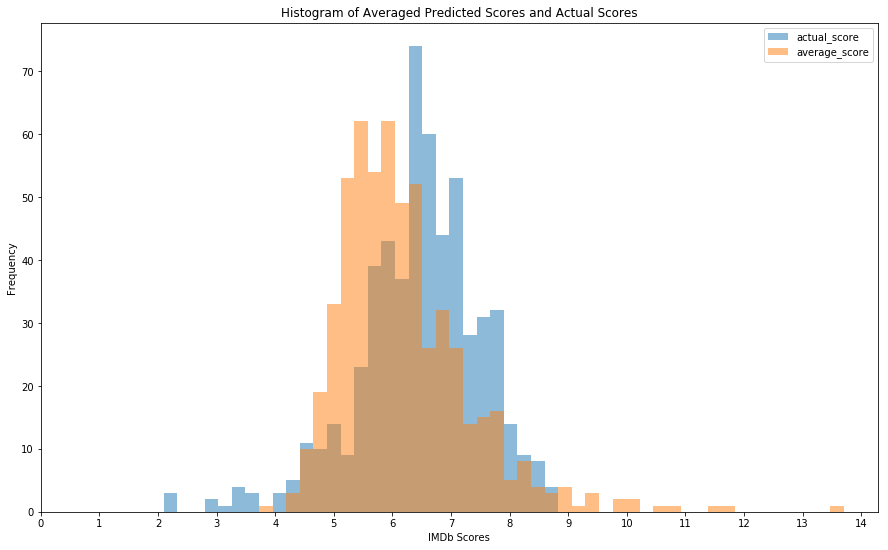

In [16]:
# Visualize distribution of actual scores and averaged predicted scores using histograms
plot_cols = ['actual_score', 'average_score']
plt.clf();
plt.figure;
master_df[plot_cols].plot.hist(alpha=0.5, bins=50, figsize=(15, 9))
plt.xticks(np.arange(0, 15, step = 1));
plt.xlabel('IMDb Scores');
plt.title('Histogram of Averaged Predicted Scores and Actual Scores');

From a visual inspection of the two distributions, it seems that the averaged predicted IMDb scores have been shifted to the left from the actual scores. This can be confirmed by looking at the means and standard deviations of the two distributions.

In [17]:
# Find the averages and standard deviations of the two distributions
actual_mean = master_df.actual_score.mean(axis=0)
actual_std = master_df.actual_score.std(axis=0)
print 'The mean of the actual IMDb scores is:', actual_mean
print 'The standard deviation of the actual IMDb scores is: %.4f\n' % actual_std

predict_mean = master_df.average_score.mean(axis=0)
predict_std = master_df.average_score.std(axis=0)
print 'The mean of the actual IMDb scores is:', predict_mean
print 'The standard deviation of the actual IMDb scores is: %.4f' % predict_std

The mean of the actual IMDb scores is: 6.472695035460993
The standard deviation of the actual IMDb scores is: 1.0580

The mean of the actual IMDb scores is: 6.19816258749409
The standard deviation of the actual IMDb scores is: 1.1391


Now that we know the means and standard deviations of the two distributions, we can identify the outliers as any value lying 2 standard deviations away from the mean (95% confidence interval assuming a Gaussian distribution). These values can be excluded from the analysis.

Steps going forward:
* Get Gaussian working
* Use null hypothesis testing
* Remove outliers
* Redo null hypothesis testing
* Speculate on potential causes for results

Overachiving status:
* Look at shape of trainining data distributions vs. test distribution (need to change script to add training indices into the 'prediction_results' folder)